# 4.3 Solution landscape

In this notebook, we explore the solution landscape of the map equation for the Jazz network.

We run Infomap repeatedly and with different seeds to generate various partitions and cluster them to identify the partition clusters in the map equation's solution landscape.

### Setup

In [1]:
# To install or upgrade to to the latest version of Infomap, see https://mapequation.github.io/infomap/
# pip install infomap / pip install --upgrade infomap
import sys
import infomap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import Image
from scipy.interpolate import griddata
import umap
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set(style="white")

### Update to the latest partition validation code (requires a gcc compiler)

In [2]:
%%bash
#Clone partition-validation repo if it does not exist, otherwhise pull. Then compile.
if [ ! -d "partition-validation" ] ; then
    git clone https://github.com/mapequation/partition-validation.git
else
    git -C partition-validation pull
fi
make -C partition-validation

Already up to date.
make: `partition-validation' is up to date.


### Find communities with Infomap

In [3]:
def findCommunities(networkName="data/jazz.net", seed=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    print(f"Find communities in {networkName} with Infomap...",end="")
    im = infomap.Infomap(f"-s {seed} --silent --two-level")
    im.read_file(networkName)
    im.run()

    print(f"{im.num_top_modules} top modules with codelength: {im.codelength}")
    communityDict = {node.node_id: ":".join(map(str, node.path[:-1]))
                    for node in im.nodes}
    
    return im.codelength, [path for _, path in sorted(communityDict.items())]

### Analyze partition robustness
#### Definitions

<dl>
  <dt>Distance threshold</dt>
  <dd>The maximum weighted Jaccard distance between a cluster center and any other partition in the same cluster.</dd>    
    
  <dt>Validation score</dt>
  <dd>The fraction of validation partitions that fit into existing clusters.</dd>

  <dt>Validation set size</dt>
  <dd>The number of partitions hold out when measuring the validation score.</dd>       
    
  <dt>Accuracy</dt>
  <dd>The threshold validation score for a complete solution landscape.</dd>
</dl>

#### Partition clustering algorithm

1. Order all p network partitions from highest to lowest quality (from shortest to longest code length).
1. Let the highest quality network partition form cluster center 1.
1. Repeat until all network partitions have been clustered. Among the not yet clustered partitions, pick the one with the highest quality and assign it to the first of the m cluster centers it is closer to than the distance threshold. If no such cluster center exists, let it form cluster center m + 1.
#### Solution landscape completeness algorithm

To determine the sufficient number of searches for a solution that is good enough given the distance threshold and solution landscape accuracy, we

1. Run Infomap twice the validation set size and add the new partitions to previously identified partitions.
1. Randomly split all partitions into validation and training sets. Run the partition clustering algorithm on the training set and measure the validation score on the validation set. Resample a specified number of times for a better estimate.
1. Repeat 1. and 2. until the validation score is higher than the specified accuracy.
#### Guidelines

Generally, a solution landscape with a small distance threshold and a high accuracy requires many partitions. Moreover, networks with a flat solution landscape, characterized by relatively small differences in code length for distant solutions, require more partitions than networks with a peaked solutions landscape, characterized by rather significant differences in code length for similar solutions.

When exploring the solution landscape of a network, start with a relatively large distance threshold, say 0.3, for fast results. If the alluvial diagram shows that the solutions vary more than desired, reduce the distance threshold and repeat the analysis. Continue this procedure until the solution landscape is complete for an acceptable distance threshold.

### Networks

In [4]:
network = 'data/jazz.net' #  A network with a peaked solutions landscape characterized by relatively large code length differences for similar solutions.
accuracy = 0.9 # Requiring 90 percent of new solutions to fall into existing solclusters
distance_threshold = 0.02 # A partition 

networkname = network.split("data/", 1)
networkname = networkname[len(networkname) - 1]

### Find 200 partitions

In [5]:
partitions_df = pd.DataFrame() 
niter = 200
for i in range(niter):
    print(f"Attempt {i+1}: ", end="")
    codelength, communities = findCommunities(network, i+123)
    communities.insert(0, codelength)
    partitions_df = pd.concat([partitions_df, pd.DataFrame(communities,columns = [str(i)])], axis=1)

Attempt 1: Find communities in data/jazz.net with Infomap...6 top modules with codelength: 6.862755928271476
Attempt 2: Find communities in data/jazz.net with Infomap...6 top modules with codelength: 6.909624073579014
Attempt 3: Find communities in data/jazz.net with Infomap...5 top modules with codelength: 6.863047469426565
Attempt 4: Find communities in data/jazz.net with Infomap...4 top modules with codelength: 6.910985478780375
Attempt 5: Find communities in data/jazz.net with Infomap...5 top modules with codelength: 6.864742285794233
Attempt 6: Find communities in data/jazz.net with Infomap...6 top modules with codelength: 6.909124465854308
Attempt 7: Find communities in data/jazz.net with Infomap...5 top modules with codelength: 6.911795900173009
Attempt 8: Find communities in data/jazz.net with Infomap...5 top modules with codelength: 6.864742285794233
Attempt 9: Find communities in data/jazz.net with Infomap...6 top modules with codelength: 6.871930970581841
Attempt 10: Find co

### Identify partition clusters

In [6]:
distance_threshold = 0.02
partitions_df.sort_values(by=0, axis=1,inplace=True)
codelengths = partitions_df.loc[0,:].to_numpy()
partitions_df.drop(0, axis=0,inplace=False).to_csv(r'output/partitions.csv',index=False,header=False,sep=' ')
!partition-validation/partition-validation -s 123 -t $distance_threshold output/partitions.csv output/partitions_clustering.txt

Version: Feb 23, 2022.
Command: partition-validation/partition-validation -s 123 -t 0.02 output/partitions.csv output/partitions_clustering.txt
Setup:
--> Using seed: 123
--> Will cluster partitions such that no partition is farther away from its center than: 0.02
--> Will read partitions from file: output/partitions.csv
--> Will write clusters to file: output/partitions_clustering.txt
--> Will use number of threads: 1
Reading partitions file with 200 partitions...of 198 nodes...done!
Clustering 200 partitions:
--> Writing 40 clusters...done!


### Read partition clusters

In [7]:
# Only influde best maxclusters clusters
maxclusters = 20
partition_clusters_df = pd.read_csv('output/partitions_clustering.txt', delimiter=' ', comment='#')
Nclusters = partition_clusters_df['ClusterId'].max()
print(f"Solution landscape contains {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

if Nclusters > maxclusters:
    partition_clusters_df.drop(partition_clusters_df[partition_clusters_df.ClusterId > maxclusters].index, inplace=True)
    Nclusters = partition_clusters_df['ClusterId'].max()
    print(f"Including only the best {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

Solution landscape contains 40 clusters with 200 partitions.
Including only the best 20 clusters with 113 partitions.


### Identify cluster sizes

In [8]:
clusterSizes = partition_clusters_df['ClusterId'].value_counts(sort=False)
maxClusterSize = max(clusterSizes)
solution_landscape_df = clusterSizes.to_frame('ClusterId').rename(columns={'ClusterId':'clustersize'})
solution_landscape_df

,clustersize
ClusterId,
1,8
2,8
3,6
4,50
5,1
6,6
7,3
8,1
9,1


### Identify cluster centers and code lengths

In [9]:
Nclusters = partition_clusters_df['ClusterId'].max()
clusterCenters = np.empty(Nclusters)

for clusterId in range(1, Nclusters + 1):
    clusterCenters[clusterId - 1] = partition_clusters_df['PartitionId'][(partition_clusters_df['ClusterId'] == clusterId).idxmax()]

clusterCenters = clusterCenters.astype(int)
clusterCenterCodelengths = codelengths[clusterCenters - 1]
solution_landscape_df['partitionid'] = clusterCenters.tolist()
solution_landscape_df['codelength'] = clusterCenterCodelengths.tolist()

### Identify pairwise cluster center distances

In [10]:
distances_df = pd.read_csv('output/partitions_clustering_distances.txt', delimiter=' ', comment='#')
distances_df.drop(distances_df[(distances_df['ClusterId1'] > maxclusters) | (distances_df['ClusterId2'] > maxclusters)].index, inplace=True)
distances_df.head()

,ClusterId1,ClusterId2,Distance
0,1,2,0.140729
1,1,3,0.053765
2,1,4,0.029196
3,1,5,0.047624
4,1,6,0.073109


### Create partition distance matrix and identify coordinates in 2D with [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)

In [11]:
row = distances_df.to_numpy()[:,0].astype(int) - 1
col = distances_df.to_numpy()[:,1].astype(int) - 1
distances = distances_df.to_numpy()[:,2]
distance_matrix = np.zeros((Nclusters, Nclusters), dtype=distances.dtype)
distance_matrix[row, col] = distances
distance_matrix[col, row] = distances # Add transpose
U = umap.UMAP(metric='precomputed', n_neighbors=Nclusters - 1, min_dist=distance_threshold)
out = U.fit_transform(distance_matrix)
solution_landscape_df['xcoord'] = out[:, 0]
solution_landscape_df['ycoord'] = out[:, 1]
solution_landscape_df.head()

/opt/homebrew/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,clustersize,partitionid,codelength,xcoord,ycoord
ClusterId,,,,,
1,8,1,6.861230,7.520631,-0.327365
2,8,9,6.862756,7.221211,3.325753
3,6,16,6.862964,8.819550,0.378838
4,50,21,6.863047,7.193246,-0.090269
5,1,50,6.863629,6.596949,0.009807


### Visualize solution landscape with contour plot

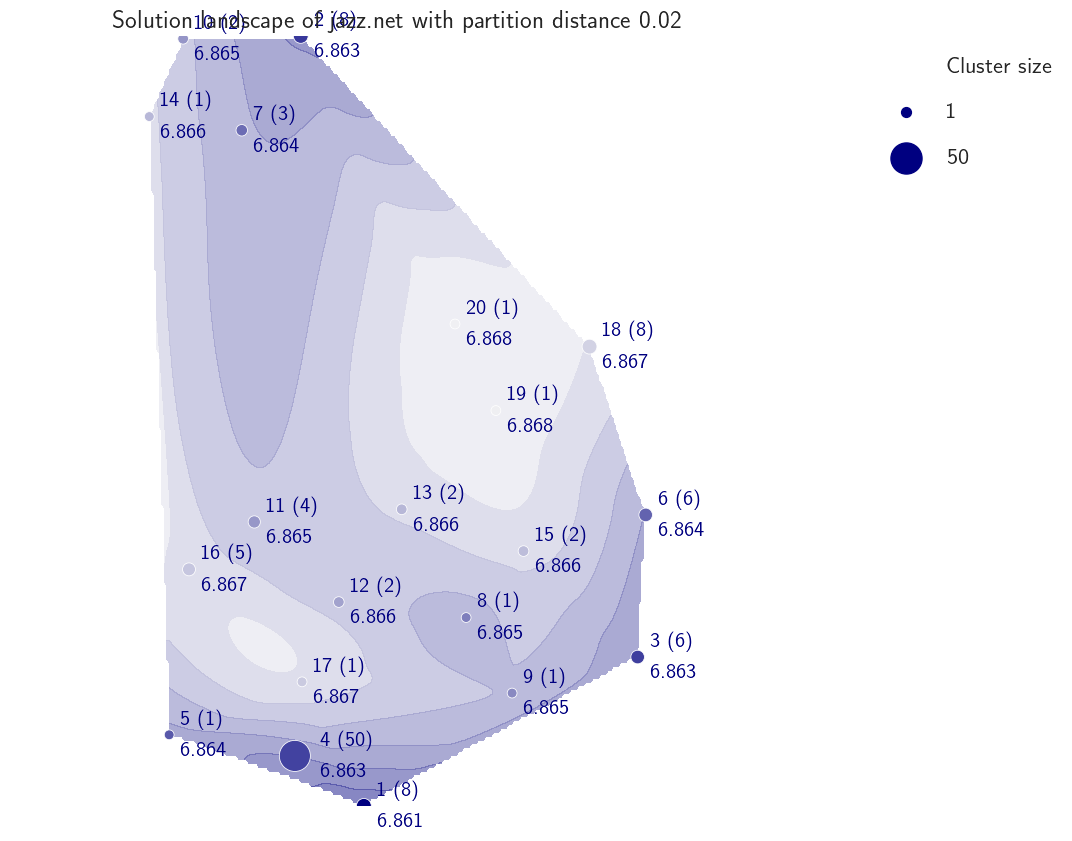

In [12]:
x = solution_landscape_df['xcoord'].values
y = solution_landscape_df['ycoord'].values
codelength = solution_landscape_df['codelength'].values

def plot_contour(x, y, codelength, resolution=200, contour_method='cubic'):
    resolution = f"{resolution}j"
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = list(zip(x, y))
    Z = griddata(points, codelength, (X, Y), method=contour_method)
    return X, Y, Z

X, Y, Z = plot_contour(x, y, codelength, resolution=200, contour_method='cubic')

palette = sns.light_palette("navy", reverse=True, as_cmap=True)
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
p0 = ax.contourf(X, Y, Z, cmap=palette, alpha=0.5)
#cbaxes = f.add_axes([0.8, 0.1, 0.03, 0.8])
#cbar = f.colorbar(p0, cax=cbaxes)
p1 = sns.scatterplot(x="xcoord", y="ycoord", hue="codelength", size="clustersize",
            sizes=(50, 500), alpha=1, palette=palette, legend="full",
            data=solution_landscape_df)
plt.axis('equal')
plt.title(f'Solution landscape of {networkname} with partition distance {distance_threshold}')
plt.xlabel('')
#plt.xlabel('Embedded partition distance')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
handles, labels = ax.get_legend_handles_labels()
for handle in handles[Nclusters + 1:]:
    handle.set_color(palette(0))
labels[Nclusters + 1] = 'Cluster size'
#handlestepsize = max(int((len(handles)-(Nclusters+1))/4),1)
plt.legend([handles[Nclusters + 1], handles[Nclusters + 2], handles[-1]],
           [labels[Nclusters + 1], labels[Nclusters + 2], labels[-1]],
           bbox_to_anchor=(1.1, 1), loc='upper left', frameon=False, ncol=1, labelspacing=1.1)

for clusterId in range(1, len(out) + 1):
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 * solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] - 0.1, 
            np.around(solution_landscape_df['codelength'].iloc[clusterId - 1], decimals=3),
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 *solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] + 0.05,
            f"{clusterId} ({solution_landscape_df['clustersize'].iloc[clusterId - 1]})",
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')

plt.savefig(f"output/solution_landscape_{networkname.split('.net')[0]}_d={distance_threshold}_a={accuracy}.png",
            bbox_inches="tight")    


**Figure 1** Solution landscape. Circles represent partition clusters with size for the number of partitions in the cluster and color for the code length of the cluster center partition. Each cluster center is labeled by its number (ordered by increasing code length), the number of partitions it contains in parenthesis, and the code length of the cluster center partition. 